# Linear Diffusion

In this section we show how we obtained the results in the supplementary material
where we used the force law $F(\ell_i) = k(a/\ell_i - s)$ so that we obtain
linear diffusion $D(q) = k$. The parameter $a$ is set to $1$ and is only used
so that $a/\ell_i$ has units of length. To start, let us load in the
packages we will need.

In [1]:
using StepwiseEQL
using CairoMakie
using EpithelialDynamics1D
using OrdinaryDiffEq
using LinearSolve
using Random
using DataInterpolations
using Optimization
using OptimizationNLopt
using PreallocationTools
using SpecialFunctions
using Setfield

For the initial condition, we define it according to a Gaussian initial density.
In particular, we let the initial density be given by
$$
q_0(x) = \frac{A}{\sqrt{2\mathrm{\pi}\sigma}}\exp\left\{-\frac{1}{2}\left(\frac{x-L_0/2}{\sigma}\right)^2\right\},
$$
where $A = N(0)/\operatorname{erf}[L_0\sqrt{2}/4\sigma]$, $L_0=10$, $\sigma^2 = 3$,
$N(0) = 40$, and $\operatorname{erf}$ is the error function. To obtain the
initial condition from this, we solve
$$
(x_2(0), \ldots, x_{40}(0)) = \operatorname*{argmin}_{\substack{x_2(0), \ldots, x_{40}(0),\\ 0<x_2(0)<\cdots<x_{40}(0)<L_0}}\sum_{i=2}^{40}\left(q_0\left(x_i(0)\right) - q_i\right)^2,
$$
where $q_i$ is the density using `StepwiseEQL.cell_density` and noting that we also have $x_1(0)=0$ and $x_{41}(0) = L_0$.
The code that follows obtains this initial condition, where we also impose symmetry of the densities about $x=L_0/2$.

In [2]:
function initial_density(x, p)
    (; σ, L₀, N₀) = p
    return N₀ * exp(-(2x - L₀)^2 / (8σ^2)) / (erf(L₀ * sqrt(2) / (4σ)) * sqrt(2π * σ^2))
end
function impose_symmetry!(ξ, x)
    _ξ = get_tmp(ξ, x)
    for i in eachindex(x)
        _ξ[i] = x[i]
        if i ≠ firstindex(x)
            _ξ[lastindex(x)+i-1] = L₀ - x[end-i+1]
        end
    end
    return _ξ
end
function objective_function(x, p)
    ℓ = zero(eltype(x))
    ξ = impose_symmetry!(p.ξ, x)
    for i in eachindex(ξ)
        qᵢ = initial_density(ξ[i], p)
        q̂ᵢ = StepwiseEQL.cell_density(ξ, i)
        ℓ += (qᵢ - q̂ᵢ)^2
    end
    return ℓ
end
σ, L₀, N₀ = sqrt(3.0), 10.0, 40
p = (σ=σ, L₀=L₀, N₀=N₀, ξ=DiffCache(zeros(N₀ + 1)))
lb = fill(0.0, 1 + N₀ ÷ 2)
lb[end] = L₀ / 2
ub = fill(L₀ / 2, 1 + N₀ ÷ 2)
ub[begin] = 0.0
x = collect(LinRange(0, L₀ / 2, 1 + N₀ ÷ 2))
optf = OptimizationFunction(objective_function, Optimization.AutoForwardDiff())
optp = OptimizationProblem(optf, x, p, lb=lb, ub=ub)
optsol = solve(optp, NLopt.LD_LBFGS())
initial_condition = impose_symmetry!(zeros(N₀ + 1), optsol.u)

┌ Warning: The supplied DiffCache was too small and was enlarged. This incurs allocations
│     on the first call to `get_tmp`. If few calls to `get_tmp` occur and optimal performance is essential,
│     consider changing 'N'/chunk size of this DiffCache to 12.
└ @ PreallocationTools C:\Users\User\.julia\packages\PreallocationTools\nhCNl\src\PreallocationTools.jl:155


41-element Vector{Float64}:
  0.0
  1.5787033523246374
  2.1340980079211676
  2.4973813897938477
  2.774109159733593
  3.003581585705231
  3.2020192021768916
  3.3793419906978626
  3.5408616392248677
  3.690628759412924
  ⋮
  6.459138360775132
  6.620658009302137
  6.797980797823108
  6.996418414294769
  7.225890840266407
  7.502618610206152
  7.8659019920788324
  8.421296647675362
 10.0

Now that we have our initial condition, let us define and solve the `CellProblem`.

In [3]:
final_time = 100.0
η = 1.0
s = 1.0
k = 20.0
Fp = (s=s, k=k)
F = (δ, p) -> k * (inv(δ) - p.s)
prob = CellProblem(;
    final_time,
    initial_condition,
    damping_constant=η,
    force_law=F,
    force_law_parameters=Fp,
    fix_right=false)
sol = solve(prob, Tsit5(), saveat=0.01)

retcode: Success
Interpolation: 1st order linear
t: 10001-element Vector{Float64}:
   0.0
   0.01
   0.02
   0.03
   0.04
   0.05
   0.06
   0.07
   0.08
   0.09
   ⋮
  99.92
  99.93
  99.94
  99.95
  99.96
  99.97
  99.98
  99.99
 100.0
u: 10001-element Vector{Vector{Float64}}:
 [0.0, 1.5787033523246374, 2.1340980079211676, 2.4973813897938477, 2.774109159733593, 3.003581585705231, 3.2020192021768916, 3.3793419906978626, 3.5408616392248677, 3.690628759412924  …  6.309371240587076, 6.459138360775132, 6.620658009302137, 6.797980797823108, 6.996418414294769, 7.225890840266407, 7.502618610206152, 7.8659019920788324, 8.421296647675362, 10.0]
 [0.0, 1.3651358188376719, 1.9490241066453966, 2.3335217503330896, 2.628603228897222, 2.872935877679148, 3.0845791597576984, 3.273459199755298, 3.4456439133940746, 3.605134305410975  …  6.394865542781103, 6.554355715417048, 6.726539859163963, 6.915418334715366, 7.127056987526195, 7.371374413948285, 7.666397356929318, 8.050605150886081, 8.632191479495392

Now we look at the data and compare it to the continuum limit.

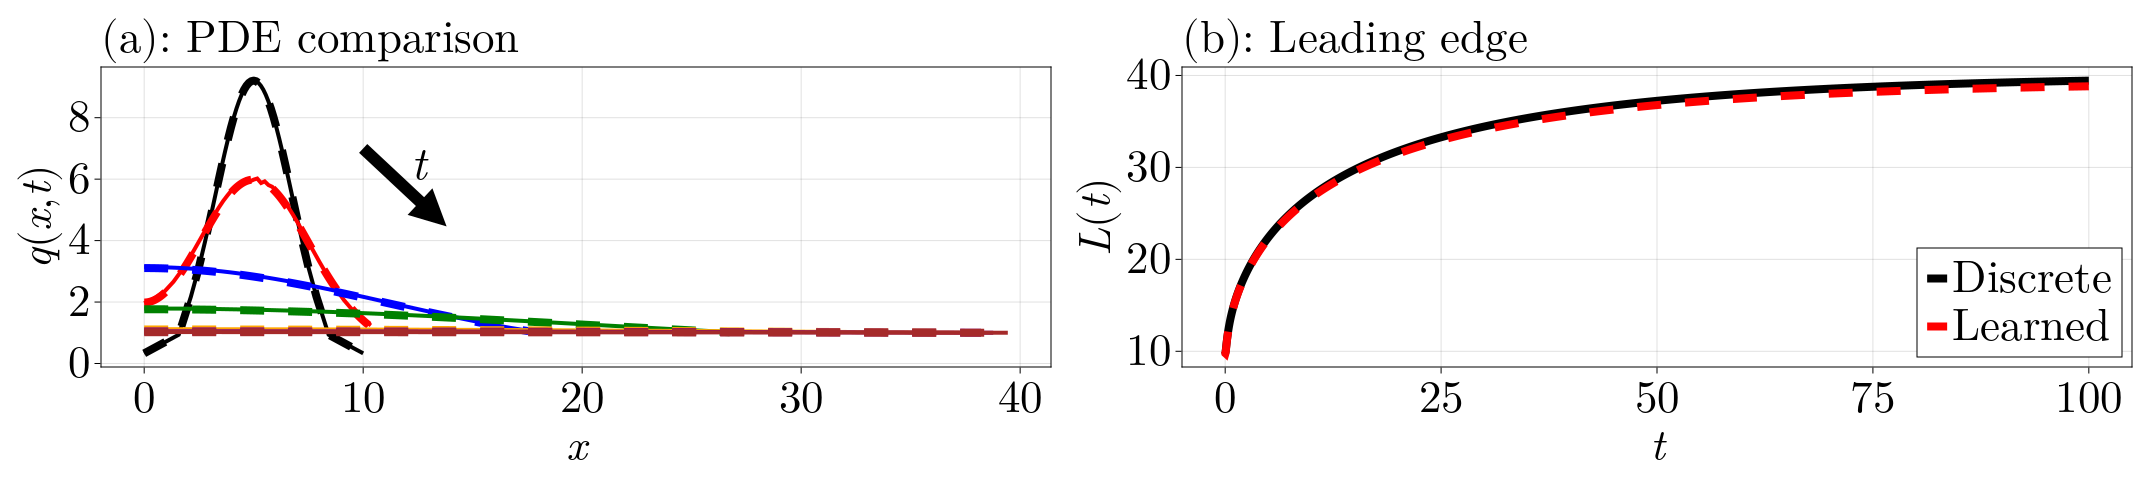

In [4]:
pde_continuum = continuum_limit(prob, 2500)
pde_sol = solve(pde_continuum, TRBDF2(linsolve=KLUFactorization()), saveat=sol.t)
pde_ξ = pde_continuum.geometry.mesh_points
pde_L = pde_sol[end, :]
pde_q = pde_sol[begin:(end-1), :]
cell_q = node_densities.(sol.u)
cell_r = sol.u
cell_L = sol[end, :]
t = (0.0, 1 / 10, 2.0, 10.0, 50.0, 75.0, 100.0)
colors = (:black, :red, :blue, :green, :orange, :purple, :brown)
t_idx = [findlast(≤(τ), sol.t) for τ in t]
fig = Figure(fontsize=45)
ax1 = Axis(fig[1, 1], xlabel=L"x", ylabel=L"q(x,t)", width=950, height=300,
    title=L"(a):$ $ PDE comparison", titlealign=:left,
    xticks=(0:10:40, [L"%$s" for s in 0:10:40]), yticks=(0:2:10, [L"%$s" for s in 0:2:10]))
for (j, i) in enumerate(t_idx)
    lines!(ax1, pde_ξ * pde_L[i], pde_q[:, i], color=colors[j], linestyle=:dash, linewidth=8)
    lines!(ax1, cell_r[i], cell_q[i], color=colors[j], linewidth=4, label=L"%$(t[j])")
end
arrows!(ax1, [10.0], [7.0], [3.0], [-2.0], color=:black, linewidth=12, arrowsize=50)
text!(ax1, [12.2], [5.7], text=L"t", color=:black, fontsize=47)
ax2 = Axis(fig[1, 2], xlabel=L"t", ylabel=L"L(t)", width=950, height=300,
    title=L"(b):$ $ Leading edge", titlealign=:left,
    xticks=(0:25:100, [L"%$s" for s in 0:25:100]), yticks=(0:10:40, [L"%$s" for s in 0:10:40]))
lines!(ax2, sol.t, cell_L, color=:black, linewidth=8, label=L"$ $Discrete")
lines!(ax2, pde_sol.t, pde_L, color=:red, linestyle=:dash, linewidth=8, label=L"$ $Learned")
axislegend(position=:rb)
resize_to_layout!(fig)
fig

Let us now apply our equation learning procedure to this problem.

In [5]:
diffusion_basis = PolynomialBasis(-2, 2)
rhs_basis = PolynomialBasis(1, 5)
moving_boundary_basis = PolynomialBasis(-2, 2)
eql_sol = stepwise_selection(sol;
    diffusion_basis, rhs_basis, moving_boundary_basis,
    mesh_points=100, initial=:none,
    threshold_tol=(q=0.3, dL=0.2))

StepwiseEQL Solution.
    D(q) = θ₃ᵈ ϕ₃ᵈ(q)
    H(q) = θ₂ʰ ϕ₂ʰ(q) + θ₅ʰ ϕ₅ʰ(q)
    E(q) = θ₃ᵉ ϕ₃ᵉ(q)
┌──────┬───────────────────────────────┬───────────────────────────────┬───────────────────────────────┬────────┐
│ Step │  θ₁ᵈ   θ₂ᵈ    θ₃ᵈ   θ₄ᵈ   θ₅ᵈ │  θ₁ʰ   θ₂ʰ   θ₃ʰ   θ₄ʰ    θ₅ʰ │  θ₁ᵉ   θ₂ᵉ    θ₃ᵉ   θ₄ᵉ   θ₅ᵉ │   Loss │
├──────┼───────────────────────────────┼───────────────────────────────┼───────────────────────────────┼────────┤
│    1 │ 0.00  0.00   0.00  0.00  0.00 │ 0.00  0.00  0.00  0.00   0.00 │ 0.00  0.00   0.00  0.00  0.00 │   0.76 │
│    2 │ 0.00  0.00  19.18  0.00  0.00 │ 0.00  0.00  0.00  0.00   0.00 │ 0.00  0.00   0.00  0.00  0.00 │   1.14 │
│    3 │ 0.00  0.00  19.18  0.00  0.00 │ 0.00  0.00  0.00  0.00  -0.02 │ 0.00  0.00   0.00  0.00  0.00 │   0.98 │
│    4 │ 0.00  0.00  19.18  0.00  0.00 │ 0.00  0.00  0.00  0.00  -0.02 │ 0.00  0.00  20.05  0.00  0.00 │  -5.05 │
│    5 │ 0.00  0.00  19.18  0.00  0.00 │ 0.00  0.42  0.00  0.00  -0.42 │ 0.00  0.00  20.05  0.00  0.0

Now we look at the results.

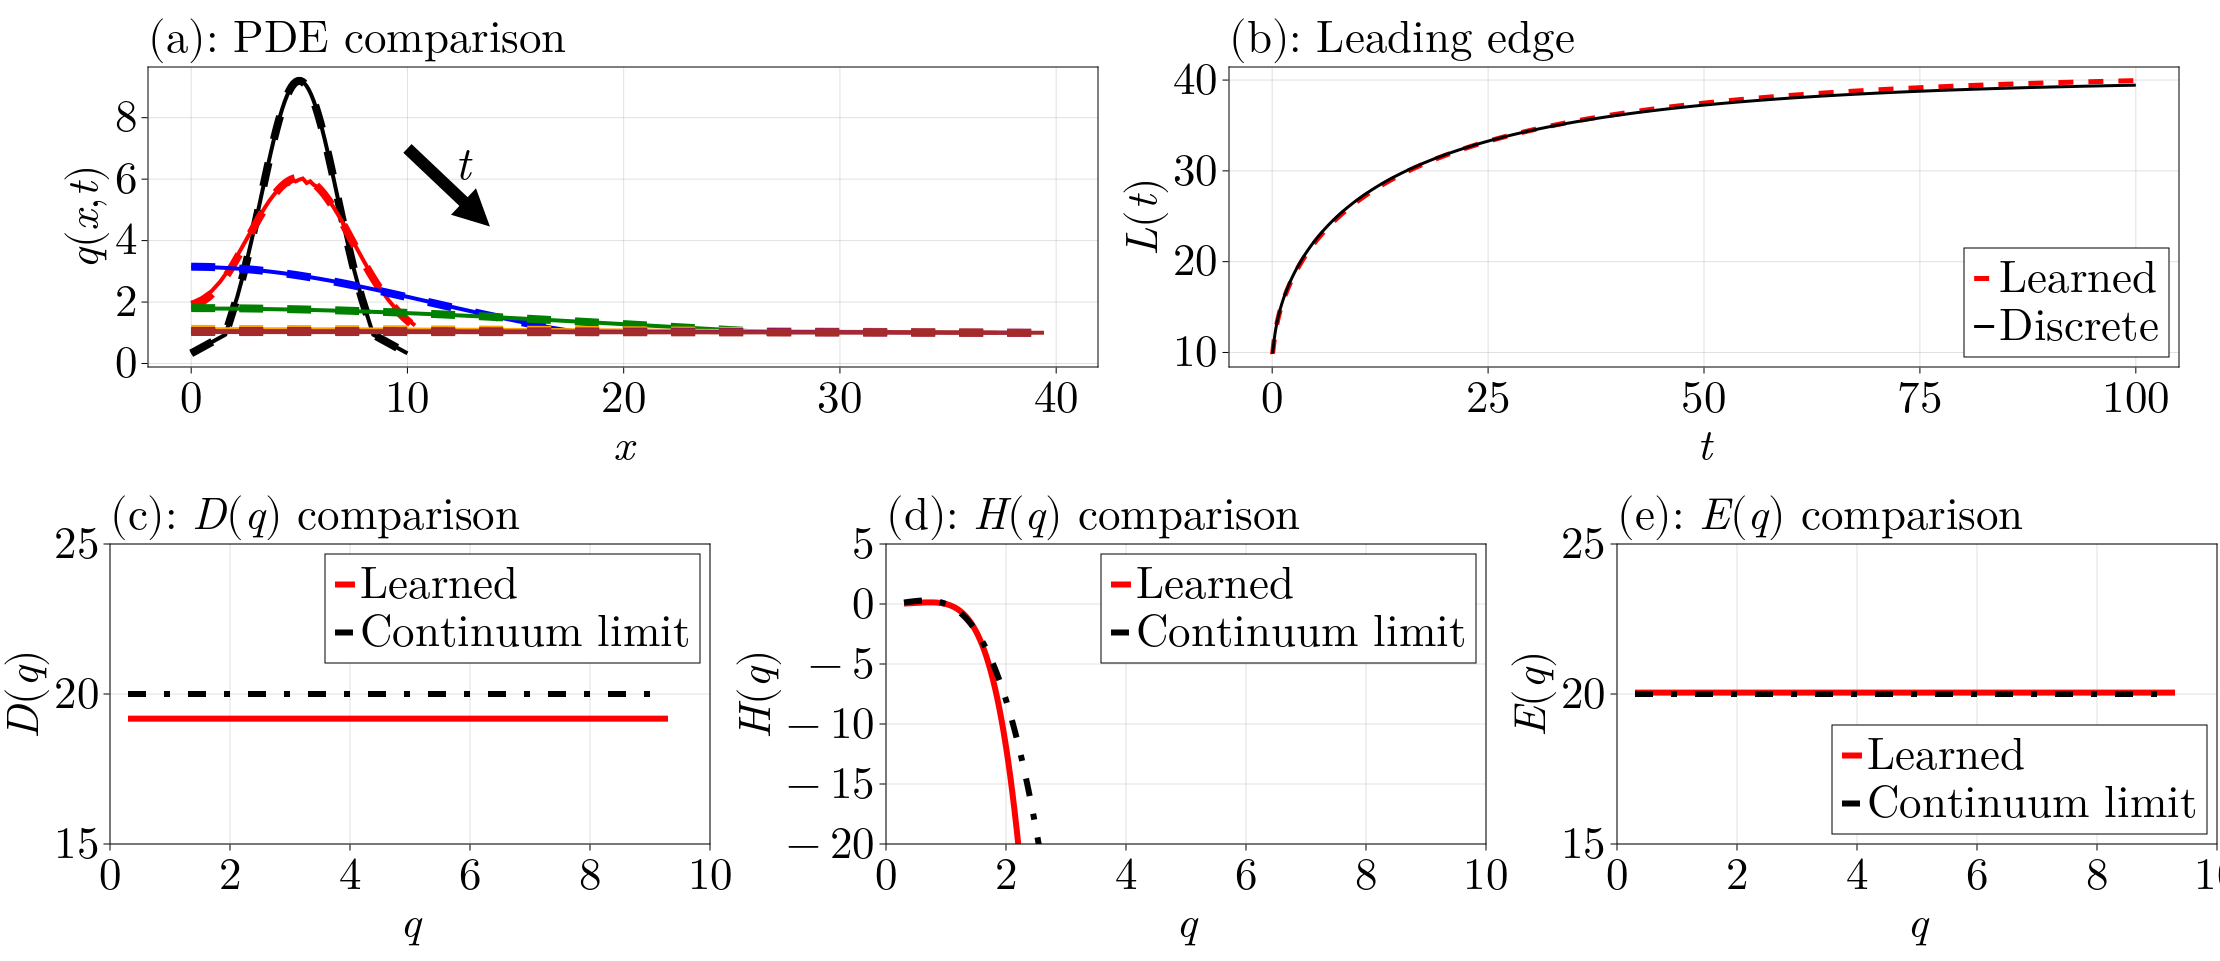

In [6]:
function plot_results(eql_sol, sol, k, s, η, diffusion_basis, rhs_basis, moving_boundary_basis, conserve_mass=false)
    t = (0.0, 1 / 10, 2.0, 10.0, 50.0, 75.0, 100.0)
    prob = sol.prob.p
    prob = @set prob.final_time = 100.0
    sol = solve(prob, Tsit5(), saveat=[collect(t); LinRange(0, 100, 2500)] |> sort |> unique)
    time_indices = [findlast(≤(τ), sol.t) for τ in t]
    colors = (:black, :red, :blue, :green, :orange, :purple, :brown)

    pde = eql_sol.pde
    pde = @set pde.final_time = 100.0 # need to resolve so that we plot over the complete time interval
    pde_sol = solve(pde, TRBDF2(linsolve=KLUFactorization()), saveat=sol.t)
    pde_continuum = deepcopy(pde)
    pde_continuum.diffusion_parameters.θ .= [0, 0.0, k / η, 0.0, 0]
    pde_continuum.boundary_conditions.rhs.p.θ .= [0, 2.0, -2.0, 0, 0]
    pde_continuum.boundary_conditions.moving_boundary.p.θ .= [0, 0, k / η, 0, 0]
    pde_ξ = pde_continuum.geometry.mesh_points
    pde_L = pde_sol[end, :]
    pde_q = pde_sol[begin:(end-1), :]
    cell_q = node_densities.(sol.u)
    cell_r = sol.u
    cell_L = sol[end, :]

    q_range = LinRange(0.3, 9.3, 250)

    fig = Figure(fontsize=45, resolution=(2220, 961))
    top_grid = fig[1, 1] = GridLayout(1, 2)
    bottom_grid = fig[2, 1] = GridLayout(1, 3)

    ax_pde = Axis(top_grid[1, 1], xlabel=L"x", ylabel=L"q(x,t)", width=950, height=300,
        title=L"(a):$ $ PDE comparison", titlealign=:left,
        xticks=(0:10:40, [L"%$s" for s in 0:10:40]), yticks=(0:2:10, [L"%$s" for s in 0:2:10]))
    for (j, i) in enumerate(time_indices)
        lines!(ax_pde, pde_ξ * pde_L[i], pde_q[:, i], color=colors[j], linestyle=:dash, linewidth=8)
        lines!(ax_pde, cell_r[i], cell_q[i], color=colors[j], linewidth=4, label=L"%$(t[j])")
    end
    arrows!(ax_pde, [10.0], [7.0], [3.0], [-2.0], color=:black, linewidth=12, arrowsize=50)
    text!(ax_pde, [12.2], [5.7], text=L"t", color=:black, fontsize=47)

    ax_leading_edge = Axis(top_grid[1, 2], xlabel=L"t", ylabel=L"L(t)", width=950, height=300,
        title=L"(b):$ $ Leading edge", titlealign=:left,
        xticks=(0:25:100, [L"%$s" for s in 0:25:100]), yticks=(0:10:40, [L"%$s" for s in 0:10:40]))
    lines!(ax_leading_edge, pde_sol.t, pde_L, color=:red, linestyle=:dash, linewidth=5, label=L"$ $Learned")
    lines!(ax_leading_edge, sol.t, cell_L, color=:black, linewidth=3, label=L"$ $Discrete")
    axislegend(position=:rb)

    ax_diffusion = Axis(bottom_grid[1, 1],
        xlabel=L"q", ylabel=L"D(q)", width=600, height=300,
        title=L"(c): $D(q)$ comparison", titlealign=:left,
        xticks=(0:2:10, [L"%$s" for s in 0:2:10]), yticks=(0:5:25, [L"%$s" for s in 0:5:25]))
    D_cont_fnc = q -> k / η
    D_cont = D_cont_fnc.(q_range)
    local D_sol
    try
        D_sol = diffusion_basis.(q_range, Ref(eql_sol.diffusion_theta), Ref(nothing))
    catch e
        print(e)
        D_sol = D_cont
    end
    lines!(ax_diffusion, q_range, D_sol, linewidth=6, color=:red, linestyle=:solid, label=L"$ $Learned")
    lines!(ax_diffusion, q_range, D_cont, linewidth=6, color=:black, linestyle=:dashdot, label=L"$ $Continuum limit")
    axislegend(position=:rt)
    xlims!(ax_diffusion, 0, 10)
    ylims!(ax_diffusion, 15, 25)

    ax_rhs = Axis(bottom_grid[1, 2],
        xlabel=L"q", ylabel=L"H(q)", width=600, height=300,
        title=L"(d): $H(q)$ comparison", titlealign=:left,
        xticks=(0:2:10, [L"%$s" for s in 0:2:10]), yticks=(-20:5:5, [L"%$s" for s in -20:5:5]))
    RHS_cont_fnc = q -> 2q^2 * (1 - s * q)
    RHS_cont = RHS_cont_fnc.(q_range)
    local RHS_sol
    try
        RHS_sol = rhs_basis.(q_range, Ref(eql_sol.rhs_theta), Ref(nothing))
    catch e
        print(e)
        RHS_sol = RHS_cont
    end
    lines!(ax_rhs, q_range, RHS_sol, linewidth=6, color=:red, linestyle=:solid, label=L"$ $Learned")
    lines!(ax_rhs, q_range, RHS_cont, linewidth=6, color=:black, linestyle=:dashdot, label=L"$ $Continuum limit")
    axislegend(position=:rt)
    xlims!(ax_rhs, 0, 10)
    ylims!(ax_rhs, -20, 5)

    ax_moving_boundary = Axis(bottom_grid[1, 3],
        xlabel=L"q", ylabel=L"E(q)", width=600, height=300,
        title=L"(e): $E(q)$ comparison", titlealign=:left,
        xticks=(0:2:10, [L"%$s" for s in 0:2:10]), yticks=(0:5:25, [L"%$s" for s in 0:5:25]))
    MB_cont_fnc = q -> k / η
    MB_cont = MB_cont_fnc.(q_range)
    local MB_sol
    try
        if !conserve_mass
            MB_sol = moving_boundary_basis.(q_range, Ref(eql_sol.moving_boundary_theta), Ref(nothing))
        else
            MB_sol = moving_boundary_basis.(q_range, Ref(eql_sol.diffusion_theta), Ref(nothing))
        end
    catch e
        print(e)
        MB_sol = MB_cont
    end
    lines!(ax_moving_boundary, q_range, MB_sol, linewidth=6, color=:red, linestyle=:solid, label=L"$ $Learned")
    lines!(ax_moving_boundary, q_range, MB_cont, linewidth=6, color=:black, linestyle=:dashdot, label=L"$ $Continuum limit")
    axislegend(position=:rb)
    xlims!(ax_moving_boundary, 0, 10)
    ylims!(ax_moving_boundary, 15, 25)
    fig
end
fig = plot_results(eql_sol, sol, k, s, η, diffusion_basis, rhs_basis, moving_boundary_basis)
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*